### Simple code

### Setup


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

### Data

In [48]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Synthetic binary data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=0)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Split: 70% train, 15% val, 15% test
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=0)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

### Model

Simple model for testing

In [49]:
# Model (binary)
model = torch.nn.Sequential(
    torch.nn.Linear(20, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 2)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Linear(in_features=20, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=2, bias=True)
)

### Simple code

In [50]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, metric_fn=None):
    model.train()
    running_loss, running_metric, total_samples = 0.0, 0.0, 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        running_loss += loss.item() * batch_size
        if metric_fn:
            running_metric += metric_fn(outputs, labels).item() * batch_size
        total_samples += batch_size

    avg_loss = running_loss / total_samples
    avg_metric = running_metric / total_samples if metric_fn else 0
    return avg_loss, avg_metric


def evaluate(model, dataloader, criterion, device, metric_fn=None):
    model.eval() # important!!!!!!
    running_loss, running_metric, total_samples = 0.0, 0.0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            if metric_fn:
                running_metric += metric_fn(outputs, labels).item() * batch_size
            total_samples += batch_size

    avg_loss = running_loss / total_samples
    avg_metric = running_metric / total_samples if metric_fn else 0
    return avg_loss, avg_metric


def train_model(
    model, train_loader: DataLoader, val_loader: DataLoader,
    criterion, optimizer, device,
    metric_fn=None, epochs=10,
    scheduler=None, early_stopping_patience=None
):
    best_val_loss = float('inf')
    best_model_state = None
    wait = 0
    history = {'train_loss': [], 'val_loss': [], 'train_metric': [], 'val_metric': []}

    for epoch in range(1, epochs + 1):
        train_loss, train_metric = train_one_epoch(model, train_loader, criterion, optimizer, device, metric_fn)
        val_loss, val_metric = evaluate(model, val_loader, criterion, device, metric_fn)

        if scheduler:
            scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_metric'].append(train_metric)
        history['val_metric'].append(val_metric)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f}, Metric: {train_metric:.4f} | "
              f"Val Loss: {val_loss:.4f}, Metric: {val_metric:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if early_stopping_patience and wait >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)
        print("Loaded best model.")

    return model, history


In [51]:
# Setup
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def metric_fn(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    return (preds == labels).float().mean()



# Train
model, history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    metric_fn=metric_fn,         # optional
    epochs=20,
    scheduler=scheduler,              # optional
    early_stopping_patience=3         # optional
)


Epoch 01 | Train Loss: 0.6837, Metric: 0.5571 | Val Loss: 0.6547, Metric: 0.6000
Epoch 02 | Train Loss: 0.6085, Metric: 0.6857 | Val Loss: 0.5829, Metric: 0.7933
Epoch 03 | Train Loss: 0.5362, Metric: 0.8357 | Val Loss: 0.5081, Metric: 0.8800
Epoch 04 | Train Loss: 0.4626, Metric: 0.8929 | Val Loss: 0.4329, Metric: 0.9067
Epoch 05 | Train Loss: 0.3888, Metric: 0.9200 | Val Loss: 0.3643, Metric: 0.9267
Epoch 06 | Train Loss: 0.3258, Metric: 0.9300 | Val Loss: 0.3053, Metric: 0.9333
Epoch 07 | Train Loss: 0.2754, Metric: 0.9300 | Val Loss: 0.2613, Metric: 0.9533
Epoch 08 | Train Loss: 0.2383, Metric: 0.9343 | Val Loss: 0.2296, Metric: 0.9600
Epoch 09 | Train Loss: 0.2110, Metric: 0.9429 | Val Loss: 0.2089, Metric: 0.9600
Epoch 10 | Train Loss: 0.1916, Metric: 0.9429 | Val Loss: 0.1932, Metric: 0.9600
Epoch 11 | Train Loss: 0.1775, Metric: 0.9471 | Val Loss: 0.1833, Metric: 0.9600
Epoch 12 | Train Loss: 0.1667, Metric: 0.9471 | Val Loss: 0.1760, Metric: 0.9600
Epoch 13 | Train Loss: 0.157

In [ ]:
# note it implements early stopping and saves the best model

### Add a test performance

let's remember the purpose of the val and test sets

|                              | **Validation Set**                                     | **Test Set**                           |
| ---------------------------- | ------------------------------------------------------ | -------------------------------------- |
| ✅ **Purpose**                | Tune model (monitor overfitting, early stopping, etc.) | Final performance evaluation           |
| 🔁 **Used During Training?** | Yes (after each epoch)                                 | ❌ Never used during training or tuning |
| 📉 **Affects Learning?**     | Yes (e.g., early stopping, LR sched)                   | No — used **once at the end**          |
| 📌 **Best Practice**         | Used for model selection                               | Used for final reporting only          |



I'll add a test_loader input and a test_model() function that runs once after training.

In [6]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, metric_fn=None):
    model.train()
    running_loss, running_metric, total_samples = 0.0, 0.0, 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        running_loss += loss.item() * batch_size
        if metric_fn:
            running_metric += metric_fn(outputs, labels).item() * batch_size
        total_samples += batch_size

    return running_loss / total_samples, running_metric / total_samples if metric_fn else 0


def evaluate(model, dataloader, criterion, device, metric_fn=None):
    model.eval()
    running_loss, running_metric, total_samples = 0.0, 0.0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            if metric_fn:
                running_metric += metric_fn(outputs, labels).item() * batch_size
            total_samples += batch_size

    return running_loss / total_samples, running_metric / total_samples if metric_fn else 0


def train_model(
    model, train_loader, val_loader, test_loader,
    criterion, optimizer, device,
    metric_fn=None, epochs=10,
    scheduler=None, early_stopping_patience=None
):
    best_val_loss = float('inf')
    best_model_state = None
    wait = 0
    history = {'train_loss': [], 'val_loss': [], 'train_metric': [], 'val_metric': []}

    for epoch in range(1, epochs + 1):
        train_loss, train_metric = train_one_epoch(model, train_loader, criterion, optimizer, device, metric_fn)
        val_loss, val_metric = evaluate(model, val_loader, criterion, device, metric_fn)

        if scheduler:
            scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_metric'].append(train_metric)
        history['val_metric'].append(val_metric)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f}, Metric: {train_metric:.4f} | "
              f"Val Loss: {val_loss:.4f}, Metric: {val_metric:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if early_stopping_patience and wait >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)
        print("Loaded best model.")

    # Final test set evaluation (only once)
    test_loss, test_metric = evaluate(model, test_loader, criterion, device, metric_fn)
    print(f"\nFinal Test Loss: {test_loss:.4f}, Test Metric: {test_metric:.4f}")

    return model, history


In [9]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

def accuracy_fn(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    return (preds == labels).float().mean()

# Train with test set evaluation
model, history = train_model(
    model, train_loader, val_loader, test_loader,
    criterion, optimizer, device,
    metric_fn=accuracy_fn,
    epochs=20,
    scheduler=scheduler,
    early_stopping_patience=4
)

Epoch 01 | Train Loss: 0.3964, Metric: 0.8657 | Val Loss: 0.1987, Metric: 0.9467
Epoch 02 | Train Loss: 0.1577, Metric: 0.9443 | Val Loss: 0.1595, Metric: 0.9667
Epoch 03 | Train Loss: 0.1300, Metric: 0.9557 | Val Loss: 0.1697, Metric: 0.9467
Epoch 04 | Train Loss: 0.1032, Metric: 0.9643 | Val Loss: 0.1655, Metric: 0.9467
Epoch 05 | Train Loss: 0.0865, Metric: 0.9714 | Val Loss: 0.1656, Metric: 0.9600
Epoch 06 | Train Loss: 0.0692, Metric: 0.9800 | Val Loss: 0.1678, Metric: 0.9600
Early stopping triggered.
Loaded best model.

Final Test Loss: 0.1189, Test Metric: 0.9667


Use val_loader during training (to control learning).

Use test_loader only after training ends (to report final performance).

This structure follows standard best practices used in research and production.

### Multiple metrics

metrics = {
    "accuracy": accuracy_fn,
    "precision": precision_fn,
    "f1": f1_fn,
}
Then in training/validation:

Call each metric function.

Store each one separately.

In [19]:
# --- 3. Define loss, optimizer, scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

# --- 4. Define multiple metrics ---
def accuracy_fn(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    return (preds == labels).float().mean()


"""
def dummy_precision_fn(outputs, labels):  # replace with real logic if needed
    preds = torch.argmax(outputs, dim=1)
    true_positives = ((preds == 1) & (labels == 1)).sum().float()
    predicted_positives = (preds == 1).sum().float()
    return true_positives / (predicted_positives + 1e-8)
"""


from sklearn.metrics import precision_score

def precision_fn(outputs, labels):
    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    return torch.tensor(precision_score(labels, preds, average='binary'))  # or 'macro'



metrics = {
    "accuracy": accuracy_fn,
    "precision": precision_fn
}


In [20]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, metrics=None):
    model.train()
    running_loss, total_samples = 0.0, 0
    metric_totals = {name: 0.0 for name in metrics} if metrics else {}

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size

        if metrics:
            for name, fn in metrics.items():
                metric_totals[name] += fn(outputs, labels).item() * batch_size

    avg_loss = running_loss / total_samples
    avg_metrics = {name: total / total_samples for name, total in metric_totals.items()} if metrics else {}

    return avg_loss, avg_metrics


def evaluate(model, dataloader, criterion, device, metrics=None):
    model.eval()
    running_loss, total_samples = 0.0, 0
    metric_totals = {name: 0.0 for name in metrics} if metrics else {}

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_size = labels.size(0)
            running_loss += loss.item() * batch_size
            total_samples += batch_size

            if metrics:
                for name, fn in metrics.items():
                    metric_totals[name] += fn(outputs, labels).item() * batch_size

    avg_loss = running_loss / total_samples
    avg_metrics = {name: total / total_samples for name, total in metric_totals.items()} if metrics else {}

    return avg_loss, avg_metrics


In [21]:
# --- 6. Training loop with early stopping ---
def train_model(model, train_loader, val_loader, test_loader,
                criterion, optimizer, scheduler, device,
                metrics=None, epochs=20, early_stopping_patience=3):
    
    best_val_loss = float('inf')
    best_model_state = None
    wait = 0
    history = {}

    for epoch in range(1, epochs + 1):
        train_loss, train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device, metrics)
        val_loss, val_metrics = evaluate(model, val_loader, criterion, device, metrics)

        scheduler.step(val_loss)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        for name in train_metrics:
            print(f"  Train {name}: {train_metrics[name]:.4f} | Val {name}: {val_metrics[name]:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            print(f"  No improvement. Patience {wait}/{early_stopping_patience}")
            if wait >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)
        print("Loaded best model.")

    # Final test evaluation
    test_loss, test_metrics = evaluate(model, test_loader, criterion, device, metrics)
    print(f"\nTest Results -> Loss: {test_loss:.4f}")
    for name, value in test_metrics.items():
        print(f"  Test {name}: {value:.4f}")

    return model



In [22]:
# --- 7. Run ---
trained_model = train_model(
    model,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    metrics=metrics,
    epochs=20,
    early_stopping_patience=4
)

Epoch 01 | Train Loss: 0.0495 | Val Loss: 0.2342
  Train accuracy: 0.9771 | Val accuracy: 0.9600
  Train precision: 0.9793 | Val precision: 0.9586
Epoch 02 | Train Loss: 0.0297 | Val Loss: 0.2297
  Train accuracy: 0.9971 | Val accuracy: 0.9600
  Train precision: 0.9962 | Val precision: 0.9586
Epoch 03 | Train Loss: 0.0218 | Val Loss: 0.2630
  Train accuracy: 0.9957 | Val accuracy: 0.9667
  Train precision: 0.9948 | Val precision: 0.9732
  No improvement. Patience 1/4
Epoch 04 | Train Loss: 0.0171 | Val Loss: 0.2857
  Train accuracy: 0.9986 | Val accuracy: 0.9667
  Train precision: 0.9973 | Val precision: 0.9732
  No improvement. Patience 2/4
Epoch 05 | Train Loss: 0.0140 | Val Loss: 0.2860
  Train accuracy: 0.9986 | Val accuracy: 0.9600
  Train precision: 0.9967 | Val precision: 0.9586
  No improvement. Patience 3/4
Epoch 06 | Train Loss: 0.0096 | Val Loss: 0.2858
  Train accuracy: 1.0000 | Val accuracy: 0.9600
  Train precision: 1.0000 | Val precision: 0.9586
  No improvement. Patienc

### using torchmetrics

In [24]:
#!pip install torchmetrics

In [26]:
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision

# 4. Metric setup (torchmetrics)
metrics = {
    "accuracy": BinaryAccuracy().to(device),
    "precision": BinaryPrecision().to(device)
}

def reset_metrics(metrics):
    for metric in metrics.values():
        metric.reset()

def compute_metrics(metrics, preds, labels):
    results = {}
    for name, metric in metrics.items():
        metric.update(preds, labels)
    for name, metric in metrics.items():
        results[name] = metric.compute().item()
    return results

In [ ]:
# 5. Training functions
def train_one_epoch(model, loader, criterion, optimizer, device, metrics):
    model.train()
    total_loss, total_samples = 0.0, 0
    reset_metrics(metrics)

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_samples += labels.size(0)

        preds = torch.argmax(outputs, dim=1)
        for metric in metrics.values():
            metric.update(preds, labels)

    avg_loss = total_loss / total_samples
    final_metrics = {name: metric.compute().item() for name, metric in metrics.items()}
    return avg_loss, final_metrics

def evaluate(model, loader, criterion, device, metrics):
    model.eval()
    total_loss, total_samples = 0.0, 0
    reset_metrics(metrics)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            for metric in metrics.values():
                metric.update(preds, labels)

    avg_loss = total_loss / total_samples
    final_metrics = {name: metric.compute().item() for name, metric in metrics.items()}
    return avg_loss, final_metrics

# 6. Training loop
def train_model(model, train_loader, val_loader, test_loader,
                criterion, optimizer, scheduler, device,
                metrics, epochs=20, early_stopping_patience=3):

    best_val_loss = float('inf')
    best_model_state = None
    wait = 0

    for epoch in range(1, epochs + 1):
        train_loss, train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device, metrics)
        val_loss, val_metrics = evaluate(model, val_loader, criterion, device, metrics)
        scheduler.step(val_loss)

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        for name in train_metrics:
            print(f"  Train {name}: {train_metrics[name]:.4f} | Val {name}: {val_metrics[name]:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            print(f"  No improvement. Patience {wait}/{early_stopping_patience}")
            if wait >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)
        print("Loaded best model.")

    # Final test set evaluation
    test_loss, test_metrics = evaluate(model, test_loader, criterion, device, metrics)
    print(f"\nTest Results -> Loss: {test_loss:.4f}")
    for name, value in test_metrics.items():
        print(f"  Test {name}: {value:.4f}")

    return model

# 7. Run training
trained_model = train_model(
    model, train_loader, val_loader, test_loader,
    criterion, optimizer, scheduler, device,
    metrics=metrics,
    epochs=20,
    early_stopping_patience=4
)

### Binary + multiclass compatible; tracking history

In [35]:
# 2. Synthetic binary classification
X, y = make_classification(n_samples=1000, n_features=20, n_classes=4, random_state=0, n_informative=4) # 4 classes!!!!
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=0)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=32)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

# 3. Model & training setup
model = nn.Sequential(
    nn.Linear(20, 32),
    nn.ReLU(),
    nn.Linear(32, 4)  # for multiclass
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)



from torchmetrics.classification import Accuracy, Precision





# 4. torchmetrics setup (binary or multiclass)
num_classes = 4
is_binary = num_classes == 2
metrics = {
    "accuracy": Accuracy(task="binary" if is_binary else "multiclass", num_classes=num_classes).to(device),
    "precision": Precision(task="binary" if is_binary else "multiclass", num_classes=num_classes, average='macro').to(device)
}

def reset_metrics(metrics):
    for metric in metrics.values():
        metric.reset()

def compute_metrics(metrics):
    return {name: metric.compute().item() for name, metric in metrics.items()}

# 5. Core training functions
def train_one_epoch(model, loader, criterion, optimizer, device, metrics):
    model.train()
    total_loss, total_samples = 0.0, 0
    reset_metrics(metrics)

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_samples += labels.size(0)

        preds = torch.argmax(outputs, dim=1)
        for metric in metrics.values():
            metric.update(preds, labels)

    avg_loss = total_loss / total_samples
    avg_metrics = compute_metrics(metrics)
    return avg_loss, avg_metrics

def evaluate(model, loader, criterion, device, metrics):
    model.eval()
    total_loss, total_samples = 0.0, 0
    reset_metrics(metrics)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

            preds = torch.argmax(outputs, dim=1)
            for metric in metrics.values():
                metric.update(preds, labels)

    avg_loss = total_loss / total_samples
    avg_metrics = compute_metrics(metrics)
    return avg_loss, avg_metrics

# 6. Training loop
def train_model(model, train_loader, val_loader, test_loader,
                criterion, optimizer, scheduler, device,
                metrics, epochs=20, early_stopping_patience=3):

    best_val_loss = float('inf')
    best_model_state = None
    wait = 0
    history = {
        "train_loss": [], "val_loss": [],
        **{f"train_{k}": [] for k in metrics},
        **{f"val_{k}": [] for k in metrics}
    }

    for epoch in range(1, epochs + 1):
        train_loss, train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device, metrics)
        val_loss, val_metrics = evaluate(model, val_loader, criterion, device, metrics)
        scheduler.step(val_loss)

        # Logging
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        for k in train_metrics:
            history[f"train_{k}"].append(train_metrics[k])
            history[f"val_{k}"].append(val_metrics[k])

        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        for k in train_metrics:
            print(f"  {k.capitalize()}: Train={train_metrics[k]:.4f}, Val={val_metrics[k]:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            print(f"  No improvement. Patience {wait}/{early_stopping_patience}")
            if wait >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)
        print("Loaded best model.")

    # Final test eval
    test_loss, test_metrics = evaluate(model, test_loader, criterion, device, metrics)
    print(f"\nTest Results: Loss={test_loss:.4f}")
    for k, v in test_metrics.items():
        print(f"  Test {k.capitalize()}: {v:.4f}")

    return model, history

# 7. Run
trained_model, history = train_model(
    model, train_loader, val_loader, test_loader,
    criterion, optimizer, scheduler, device,
    metrics=metrics,
    epochs=20,
    early_stopping_patience=4
)

Epoch 01 | Train Loss: 1.1470 | Val Loss: 0.9156
  Accuracy: Train=0.4814, Val=0.6600
  Precision: Train=0.4816, Val=0.6673
Epoch 02 | Train Loss: 0.8158 | Val Loss: 0.7901
  Accuracy: Train=0.6843, Val=0.6933
  Precision: Train=0.6902, Val=0.6926
Epoch 03 | Train Loss: 0.6927 | Val Loss: 0.7423
  Accuracy: Train=0.7229, Val=0.7267
  Precision: Train=0.7287, Val=0.7267
Epoch 04 | Train Loss: 0.6254 | Val Loss: 0.7255
  Accuracy: Train=0.7543, Val=0.6733
  Precision: Train=0.7577, Val=0.6771
Epoch 05 | Train Loss: 0.5679 | Val Loss: 0.6606
  Accuracy: Train=0.7814, Val=0.7533
  Precision: Train=0.7831, Val=0.7605
Epoch 06 | Train Loss: 0.5245 | Val Loss: 0.6371
  Accuracy: Train=0.7800, Val=0.7667
  Precision: Train=0.7824, Val=0.7660
Epoch 07 | Train Loss: 0.4804 | Val Loss: 0.6286
  Accuracy: Train=0.8100, Val=0.7733
  Precision: Train=0.8122, Val=0.7711
Epoch 08 | Train Loss: 0.4497 | Val Loss: 0.6030
  Accuracy: Train=0.8157, Val=0.7933
  Precision: Train=0.8208, Val=0.7886
Epoch 09

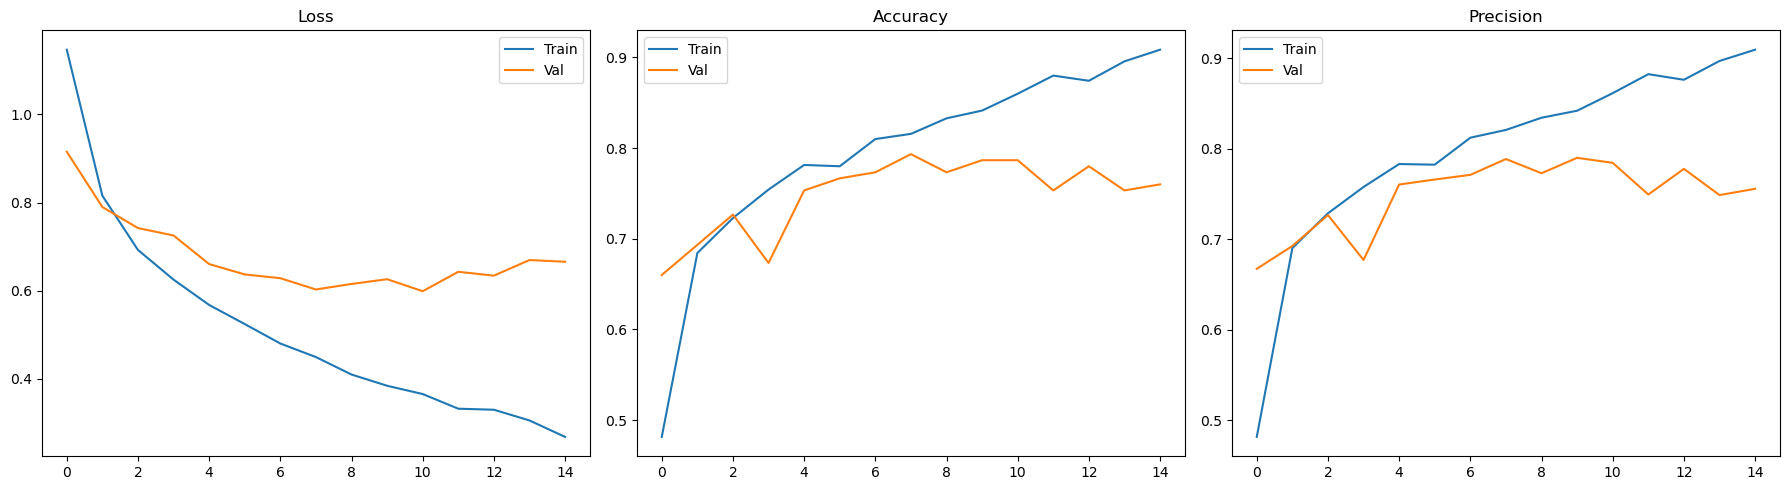

In [36]:
# plotting (and then tensrboard)
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# --- Plotting ---
def plot_history(history):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    axs[0].plot(history["train_loss"], label="Train")
    axs[0].plot(history["val_loss"], label="Val")
    axs[0].set_title("Loss")
    axs[0].legend()

    if "train_accuracy" in history:
        axs[1].plot(history["train_accuracy"], label="Train")
        axs[1].plot(history["val_accuracy"], label="Val")
        axs[1].set_title("Accuracy")
        axs[1].legend()

    if "train_precision" in history:
        axs[2].plot(history["train_precision"], label="Train")
        axs[2].plot(history["val_precision"], label="Val")
        axs[2].set_title("Precision")
        axs[2].legend()

    plt.tight_layout()
    plt.show()

plot_history(history)


In [ ]:
# create instances of the model!!!

### ANNEX - detail analysis of the training

In [37]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, metric_fn=None, track_batch_loss=False):
    """
    Trains the model for one epoch.

    Args:
        model: The neural network model to train.
        dataloader: DataLoader providing training batches.
        criterion: Loss function used for optimization.
        optimizer: Optimizer used to update model parameters.
        device: Device to run computations on ('cpu' or 'cuda').
        metric_fn (optional): Function to compute a performance metric (e.g., accuracy).
        track_batch_loss (bool): If True, tracks and returns per-batch loss and metric.

    Returns:
        avg_loss (float): Average loss over the epoch (weighted by batch size).
        avg_metric (float): Average metric value over the epoch (weighted by batch size).
        If track_batch_loss is True, also returns:
            batch_losses (list): List of loss values per batch.
            batch_metrics (list): List of metric values per batch.
    
    Note:
        The total number of samples is used for averaging because batches may not all 
        have the same size (probably the last batch).
    """
    model.train()  # Set model to training mode
    total_loss, total_metric, total_samples = 0, 0, 0
    batch_losses = []
    batch_metrics = []

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagate
        optimizer.step()  # Update parameters

        batch_size = labels.size(0)
        loss_value = loss.item()
        total_loss += loss_value * batch_size  # Accumulate total loss weighted by batch size

        if metric_fn:
            metric_value = metric_fn(outputs, labels).item()
            total_metric += metric_value * batch_size  # Accumulate total metric weighted by batch size
        else:
            metric_value = 0

        total_samples += batch_size  # Important: accounts for variable batch sizes

        if track_batch_loss:
            batch_losses.append(loss_value)  # Store batch loss
            batch_metrics.append(metric_value)  # Store batch metric

    avg_loss = total_loss / total_samples  # Compute average loss
    avg_metric = total_metric / total_samples if metric_fn else 0  # Compute average metric

    if track_batch_loss:
        return avg_loss, avg_metric, batch_losses, batch_metrics  # Return detailed results
    return avg_loss, avg_metric  # Return averages only


In [38]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 1. Create a tiny controlled dataset
class TinyDataset(Dataset):
    def __init__(self):
        # 4 samples, 2 features each (very simple)
        self.data = torch.tensor([
            [1.0, 2.0],
            [3.0, 4.0],
            [5.0, 6.0],
            [7.0, 8.0]
        ])
        # Binary labels (0 or 1)
        self.labels = torch.tensor([0, 1, 0, 1])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# 2. Create a trivial model
class TinyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(2, 2)  # 2 features -> 2 outputs (for binary classification)
        
    def forward(self, x):
        return self.fc(x)

# 3. Simple metric function we can understand
def simple_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    return (preds == labels).float().mean()

# 4. Let's test with batch_size=2 so we can see exactly what happens
tiny_dataloader = DataLoader(TinyDataset(), batch_size=2)
device = torch.device('cpu')  # Keep it simple with CPU
model = TinyModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [41]:

# modify the model with prints

def train_one_epoch_with_prints(model, dataloader, criterion, optimizer, device, metric_fn=None, track_batch_loss=False):
    model.train()
    total_loss, total_metric, total_samples = 0, 0, 0
    batch_losses = []
    batch_metrics = []

    print("\n=== Starting epoch ===")
    
    for batch_idx, (inputs, labels) in enumerate(dataloader):
        print(f"\n--- Batch {batch_idx} ---")
        print(f"Input shape: {inputs.shape}")
        print(f"Labels shape: {labels.shape}")
        print(f"Labels: {labels}")
        
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        print(f"Outputs: {outputs}")
        
        loss = criterion(outputs, labels)
        print(f"Loss item: {loss.item()}")
        
        loss.backward()
        optimizer.step()

        batch_size = labels.size(0)
        print(f"Batch size: {batch_size}")
        
        loss_value = loss.item()
        total_loss += loss_value * batch_size
        print(f"Total loss accumulation: {total_loss}")
        
        if metric_fn:
            metric_value = metric_fn(outputs, labels).item()
            total_metric += metric_value * batch_size
            print(f"Metric value: {metric_value}")
            print(f"Total metric accumulation: {total_metric}")
        else:
            metric_value = 0

        total_samples += batch_size
        print(f"Total samples so far: {total_samples}")

        if track_batch_loss:
            batch_losses.append(loss_value)
            batch_metrics.append(metric_value)

    avg_loss = total_loss / total_samples
    avg_metric = total_metric / total_samples if metric_fn else 0
    print("\n=== Final Results ===")
    print(f"Average loss: {avg_loss}")
    print(f"Average metric: {avg_metric}")

    if track_batch_loss:
        return avg_loss, avg_metric, batch_losses, batch_metrics
    return avg_loss, avg_metric

In [42]:
# running the tests
# Run with all debugging prints
print("=== Testing with metric function ===")
avg_loss, avg_metric = train_one_epoch_with_prints(
    model, tiny_dataloader, criterion, optimizer, device, 
    metric_fn=simple_accuracy
)



=== Testing with metric function ===

=== Starting epoch ===

--- Batch 0 ---
Input shape: torch.Size([2, 2])
Labels shape: torch.Size([2])
Labels: tensor([0, 1])
Outputs: tensor([[0.6006, 0.0757],
        [2.0449, 0.9108]], grad_fn=<AddmmBackward0>)
Loss item: 0.938890814781189
Batch size: 2
Total loss accumulation: 1.877781629562378
Metric value: 0.5
Total metric accumulation: 1.0
Total samples so far: 2

--- Batch 1 ---
Input shape: torch.Size([2, 2])
Labels shape: torch.Size([2])
Labels: tensor([0, 1])
Outputs: tensor([[2.3106, 2.9246],
        [3.3368, 4.1778]], grad_fn=<AddmmBackward0>)
Loss item: 0.7025575041770935
Batch size: 2
Total loss accumulation: 3.282896637916565
Metric value: 0.5
Total metric accumulation: 2.0
Total samples so far: 4

=== Final Results ===
Average loss: 0.8207241594791412
Average metric: 0.5


seg. batch = tloss = 1.88(prev) + 0.7*(2) [prev + loss item*batch size]

In [43]:
print("\n=== Testing with batch tracking ===")
avg_loss, avg_metric, batch_losses, batch_metrics = train_one_epoch_with_prints(
    model, tiny_dataloader, criterion, optimizer, device,
    metric_fn=simple_accuracy, track_batch_loss=True
)
print(f"Batch losses: {batch_losses}")
print(f"Batch metrics: {batch_metrics}")


=== Testing with batch tracking ===

=== Starting epoch ===

--- Batch 0 ---
Input shape: torch.Size([2, 2])
Labels shape: torch.Size([2])
Labels: tensor([0, 1])
Outputs: tensor([[0.4805, 0.1958],
        [1.7685, 1.1873]], grad_fn=<AddmmBackward0>)
Loss item: 0.7931374311447144
Batch size: 2
Total loss accumulation: 1.5862748622894287
Metric value: 0.5
Total metric accumulation: 1.0
Total samples so far: 2

--- Batch 1 ---
Input shape: torch.Size([2, 2])
Labels shape: torch.Size([2])
Labels: tensor([0, 1])
Outputs: tensor([[2.1601, 3.0751],
        [3.1279, 4.3867]], grad_fn=<AddmmBackward0>)
Loss item: 0.7508954405784607
Batch size: 2
Total loss accumulation: 3.08806574344635
Metric value: 0.5
Total metric accumulation: 2.0
Total samples so far: 4

=== Final Results ===
Average loss: 0.7720164358615875
Average metric: 0.5
Batch losses: [0.7931374311447144, 0.7508954405784607]
Batch metrics: [0.5, 0.5]


 Section 1: === Testing with metric function ===
This version accumulates totals:

- Total loss accumulation adds raw batch losses multiplied by batch size.

- Total metric accumulation adds the metric (e.g., accuracy) for each batch.

- Final values are averaged over total number of samples.

Final average loss and metric:

Loss: 7.87586784362793 / 4 = 1.96896696

Accuracy: 2.0 / 4 = 0.5

📌 This style is good when you want a weighted average over all samples.


🔹 Section 2: === Testing with batch tracking ===
This version additionally tracks batch-level metrics individually:

- Batch losses and Batch metrics are stored in lists.

- Still accumulates total loss and metric for the final average.

Final average loss and metric:

Loss: 3.0351319 / 4 = 0.75878298

Accuracy: 2.0 / 4 = 0.5

📌 This style is useful when you want per-batch insights, like plotting loss per batch.



🤔 Why are the results different?
The loss values differ because these are two separate runs with potentially different model weights (or input data, or loss functions).

Accuracy stays the same: 1 correct prediction per batch = 0.5 overall




-> loss.item() corresponda al batch enrerro?????????

This shows you exactly:

The input data and labels for each batch

The model outputs (before softmax)

The calculated loss

How the totals accumulate

The metric calculation (accuracy in this case)


-------
This approach lets you verify that:

The batch sizes are correct

The loss calculations make sense

The metric is being computed properly

The accumulation of totals works as expected

**Note**

is labels.shpae(0) always equal to batch size?

For Classification Tasks (Current Code)
Typical shape: (batch_size,) for single-label classification

Example: labels = tensor([0, 1, 0, 1]) → labels.size() = torch.Size([4])

labels.size(0) correctly returns 4 (batch size)

For Regression Tasks
Typical shapes:

Single-value regression: (batch_size,) (same as classification)

Multi-value regression: (batch_size, num_targets)

Example: labels = tensor([[1.2, 3.4], [5.6, 7.8]]) → labels.size() = torch.Size([2, 2])

labels.size(0) still correctly returns 2 (batch size)


in general it is.

---------
labels.size(0) always returns the batch dimension regardless of whether:

It's classification (1D tensor)

Single-output regression (1D tensor)

Multi-output regression (2D tensor)

The loss functions automatically handle different label shapes:

nn.CrossEntropyLoss() expects class indices (1D) for classification

nn.MSELoss() accepts any shape for regression


https://chat.deepseek.com/a/chat/s/4c5a5043-7fd6-4c0c-8a83-e8baf399a93b


### about loss.item()

In [52]:
import torch
import torch.nn as nn

# Example: 3 samples, 2 classes
outputs = torch.tensor([[2.0, 1.0], [0.5, 2.5], [1.2, 0.8]])  # logits
labels = torch.tensor([0, 1, 1])  # true class indices

criterion = nn.CrossEntropyLoss()  # default: reduction='mean'
loss = criterion(outputs, labels)
print(loss.item())


0.45106831192970276


 What's happening internally?
Compute per-sample losses using the negative log likelihood after softmax:

In [54]:
criterion = nn.CrossEntropyLoss(reduction='none')
per_sample_losses = criterion(outputs, labels)
print(per_sample_losses)  # tensor of shape [3]


tensor([0.3133, 0.1269, 0.9130])


In [55]:
# then pytroch computes the avearge
loss_mean = per_sample_losses.mean()
print(loss_mean.item())  # this is what loss.item() gives you with reduction='mean'

0.45106831192970276


In [56]:
# to get non average loss
criterion = nn.CrossEntropyLoss(reduction='sum')
loss = criterion(outputs, labels)
print(loss.item())  # sum of losses across the batch


1.3532049655914307


You only need to multiply loss.item() by the batch size if you're using a loss function with reduction='mean' and want to compute the total (summed) loss over all samples, for example, to correctly calculate an epoch-level average.

When using reduction='mean', loss.item() gives the average loss over the current batch, regardless of batch size.

To accumulate the correct total loss across an epoch where batch sizes may vary (especially the last batch), you must convert the mean back to total by multiplying:

total_loss += loss.item() * batch_size


then, at the end:

avg_loss = total_loss / total_samples

-----------
Let’s say two batches:

Batch 1: 4 samples, loss.item() = 1.5 → total loss = 4 × 1.5 = 6.0

Batch 2: 2 samples, loss.item() = 1.0 → total loss = 2 × 1.0 = 2.0

Total samples: 6

Epoch loss: (6.0 + 2.0) / 6 = 1.33

If you had just done:


avg = (1.5 + 1.0) / 2 = 1.25  ❌
you’d get the wrong average, because you didn’t account for the different batch sizes.

| You want...                   | Use...                                            |
| ----------------------------- | ------------------------------------------------- |
| Per-batch average loss        | `loss.item()`                                     |
| Total summed loss             | `loss.item() * batch_size`                        |
| Epoch-level average (correct) | Accumulate total as above, then `/ total_samples` |



**Note**if all batches have the same length, you don’t need to multiply by batch size, because the simple average of per-batch losses gives the correct epoch average.


❗ But if batch sizes differ?
You’d get incorrect results with a simple average.

That’s why the safe, general-purpose way is always:

python
Copiar
Editar
total_loss += loss.item() * batch_size
avg_loss = total_loss / total_samples
Use the shortcut only if you know all batch sizes are equal (e.g., drop_last=True and dataset is divisible by batch size).

.... bonus -> tensorboadr